Let's use Grad-Cam algorithm to visualise class activation heatmap of Neural Network, which contains a stack of 2 LSTMs.

In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Data normalization:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
# Make it one channel image for convolutional layer
x_train = np.expand_dims(x_train, axis = 3)
x_test = np.expand_dims(x_test, axis = 3)
# Train/val split
x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, Reshape, Dropout

features = 16
(n, x, y, c) = x_train.shape

model = Sequential()
model.add(Conv2D(features, 3, padding='same', activation='relu', input_shape=(x, y, c)))
model.add(Reshape((x, y*features)))
model.add(LSTM(128, dropout = 0.2, return_sequences=True))
model.add(LSTM(128, dropout = 0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
reshape (Reshape)            (None, 28, 448)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 28, 128)           295424    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
model.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), batch_size=64, callbacks=[EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)])

Epoch 1/100
782/782 [==============================] - 10s 9ms/step - loss: 0.8494 - accuracy: 0.7148 - val_loss: 0.0950 - val_accuracy: 0.9719
Epoch 2/100
782/782 [==============================] - 6s 7ms/step - loss: 0.1100 - accuracy: 0.9706 - val_loss: 0.0582 - val_accuracy: 0.9833
Epoch 3/100
782/782 [==============================] - 6s 7ms/step - loss: 0.0843 - accuracy: 0.9764 - val_loss: 0.0556 - val_accuracy: 0.9852
Epoch 4/100
782/782 [==============================] - 6s 7ms/step - loss: 0.0540 - accuracy: 0.9853 - val_loss: 0.0406 - val_accuracy: 0.9889
Epoch 5/100
782/782 [==============================] - 6s 7ms/step - loss: 0.0479 - accuracy: 0.9866 - val_loss: 0.0494 - val_accuracy: 0.9877
Epoch 6/100
782/782 [==============================] - 6s 7ms/step - loss: 0.0404 - accuracy: 0.9889 - val_loss: 0.0444 - val_accuracy: 0.9879
Epoch 7/100
782/782 [==============================] - 6s 7ms/step - loss: 0.0345 - accuracy: 0.9909 - val_loss: 0.0406 - val_accuracy: 0.988

In [ ]:
loss, acc = model.evaluate(x_test, y_test)
print("Accuracy:", acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0263 - accuracy: 0.9927
Accuracy: 0.9926999807357788


99.2% accuracy

In [ ]:
import tensorflow as tf

def get_gradcam_heatmap(model, img):
  # Forward pass to convolutional layer
  last_conv_layer = model.layers[0]
  last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

  # Model for next layers
  classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
  x = classifier_input
  for layer in model.layers[1:]:
    x = layer(x)
  classifier_model = tf.keras.Model(classifier_input, x)
  
  # Get state after convolutional layer
  last_conv_layer_output = last_conv_layer_model(img)
  last_conv_layer_output = tf.reshape(last_conv_layer_output, (1, 28, 28, features))
  
  # Watch gradient
  with tf.GradientTape() as tape:
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]
  
  # Get gradient
  grads = tape.gradient(top_class_channel, last_conv_layer_output)
  # Average gradient for each feature in convolution
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
  last_conv_layer_output = last_conv_layer_output.numpy()[0]
  pooled_grads = pooled_grads.numpy()
  # Multiply activation of each pixel in each feature by this avg value
  for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]

  # Get average for each pixel among features
  heatmap = np.mean(last_conv_layer_output, axis=-1)
  # Apply ReLU
  heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
  return heatmap

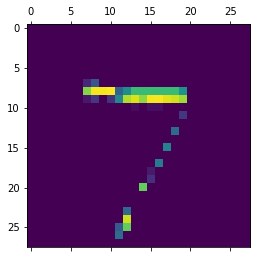

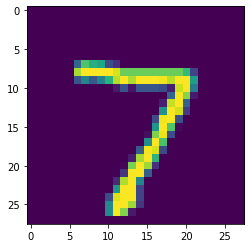

In [ ]:
import matplotlib.pyplot as plt
t_id = 0
heatmap = get_gradcam_heatmap( model, x_test[t_id] )
plt.matshow(heatmap)
plt.show()
plt.imshow(np.reshape(x_test[t_id], (28, 28)))
plt.show()